# Multi-agent DDPG for Solving Unity's "Tennis" Problem

In this notebook we report how we used Multi-agent Deep Deterministic Policy Gradient (MADDPG) algorithm to solve a modified version of Unitfy's "Tennis" environment, where we need to control two agents to play tennis in a 3D environment.

This notebook contains all the code for training and running the agent.

A demo of a pair of trained agents is shown in the gif below:

![demo](tennis-maddpg-demo.gif)

## Environment Setup

The dependencies can be set up by following the instructions from the [DRLND](https://github.com/udacity/deep-reinforcement-learning#dependencies) repo. Once it's done, the following imports should work:

In [1]:
import collections
import copy
import itertools
import math
!pip install -q dataclasses
from dataclasses import dataclass
from typing import Any, List, Tuple, Optional, Generator
import random

import numpy
import torch
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
%matplotlib inline

Note that to make GPU training work on our machine, the following version of PyTorch is used:

In [2]:
print(f"Version: {torch.__version__}; Cuda available: {torch.cuda.is_available()}")

Version: 1.7.0+cu110; Cuda available: True


Additionally, we also need to download the pre-built Unity environment, which can be downloaded for different platforms:

- Linux: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
- Mac OSX: [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip)
- Windows (32-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip)
- Windows (64-bit): [click here](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip)

Once downloaded and extracted, please set the path below accordingly.

In [3]:
ENV_PATH = '../Tennis_Linux/Tennis.x86_64'

If set up correctly, we should be able to initialize the environment:

In [4]:
class ParallelEnv:
    """A simple wrapper for the environment with parallel agents."""

    def __init__(self):
        self._env = UnityEnvironment(file_name=ENV_PATH)

        env_info = self._env.reset(train_mode=True)[self._brain_name]
        self.num_agents = len(env_info.agents)

    @property
    def _brain_name(self):
        return self._env.brain_names[0]

    @property
    def _brain(self):
        return self._env.brains[self._brain_name]

    @property
    def action_dim(self) -> int:
        """The size of a action vector."""
        return self._brain.vector_action_space_size

    @property
    def action_scale(self) -> float:
        """The scale of action values.

        Each dimension of the action vector lies in range [-scale, scale].

        """
        return 1.0

    def sample_action(self) -> numpy.array:
        """Sample an action vector uniformly at random."""
        return numpy.random.uniform(
            low=-self.action_scale,
            high=self.action_scale,
            size=(self.num_agents, self.action_dim),
        )

    @property
    def state_dim(self) -> int:
        """The size of a state vector."""
        return self._brain.vector_observation_space_size * self._brain.num_stacked_vector_observations

    def reset(self, train_mode=True) -> numpy.array:
        """Reset the environment and returns the initial state."""
        env_info = self._env.reset(train_mode=train_mode)[self._brain_name]
        init_state = env_info.vector_observations
        assert init_state.shape == (self.num_agents, self.state_dim)
        return init_state

    def step(
        self, actions: numpy.array
    ) -> Tuple[numpy.array, numpy.array, numpy.array]:
        """Take a step with the given actions.

        Returns a tuple of (states, rewards, done-flags) for all parallel agents.

        """
        assert actions.shape == (self.num_agents, self.action_dim)
        env_info = self._env.step(actions)[self._brain_name]
        return (
            numpy.array(env_info.vector_observations, dtype=numpy.float32),
            numpy.array(env_info.rewards, dtype=numpy.float32),
            numpy.array(env_info.local_done, dtype=bool),
        )

    def close(self) -> None:
        """Closes the environment."""
        self._env.close()


env = ParallelEnv()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


### Environment description

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is considered "solved" when the agents get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents).

In [5]:
print(f'Number of agents: {env.num_agents}')
print(f'Action dimension: {env.action_dim}')
print(f'States dimension: {env.state_dim}')

Number of agents: 2
Action dimension: 2
States dimension: 24


## Methodology & Implementation

To solve this problem, we experimented with MADDPG as described by Lowe et al. (2017). Compared DDPG as described by Lillicrap et al. (2015), we allow critics access to observations and actions from all agents, so that it can better guide the actors which only have access to their local observations.

As described in the paper, we let each agent to have its own actor and critic networks not shared with each other. For this simple problem, using MADDPG doesn't necessarily seem to improve convergence speed, but it's interesting to see how agents with different behaviors are able to cooperate and bounce the ball back and forth.

Additionally, we also incorporate extensions to DDPG from TD3 (Fujimoto et al. 2018), namely:

- Clipped double Q-Learning for actor-critic
- Delayed policy updates
- Target policy smoothing regularization

The incorporation of TD3 tricks into MADDPG has also been explored by Ackermann et al. (2019), which managed to achieve better result in their tests. They called the approach MATD3.

Additionally, we also used prioritized experience replay as described by Schaul et al. (2015).

### Hyper-parameters

The hyper-parameters we used is shown as the default values in the following data class:

In [6]:
@dataclass
class AgentConfig:
    horizon_length: int = 10000
    replay_buffer_size: int = 100_000
    batch_size: int = 256
    critic_lr: float = 1e-4
    actor_lr: float = 1e-4
    exploration_noise: float = 0.1
    policy_noise: float = 0.2
    policy_noise_clip: float = 0.5
    policy_update_freq: int = 2
    discount_factor: float = 0.99
    soft_update_factor: float = 0.005
    pure_exploration_steps: int = 10_000


AgentConfig()

AgentConfig(horizon_length=10000, replay_buffer_size=100000, batch_size=256, critic_lr=0.0001, actor_lr=0.0001, exploration_noise=0.1, policy_noise=0.2, policy_noise_clip=0.5, policy_update_freq=2, discount_factor=0.99, soft_update_factor=0.005, pure_exploration_steps=10000)

### Prioritized experience replay
Here we use prioritized experience replay as described in Schaul et al. (2015). Specifically, we implemented the proportional priorization variant with the sum-tree data structure.

The code for the replay buffer is as follows:

In [7]:
class PrioritizedReplayBuffer:
    """A proportionally prioritized replay buffer implemented with sum-tree."""

    _curr_index: int
    _size: int
    _max_priority: float
    _sum_tree: List[float]
    _priorities: List[float]
    _samples: List[Any]

    def __init__(self, buffer_size: int):
        assert buffer_size > 1
        self._curr_index = 0
        self._size = 0
        self._max_priority = 1.0
        self._sum_tree = [0] * (2 ** (math.floor(math.log2(buffer_size - 1)) + 1) - 1)
        self._priorities = [0] * buffer_size
        self._samples = [None] * buffer_size

    def _ancestor_indices(self, sample_index: int) -> Generator[int, None, None]:
        assert 0 <= sample_index <= len(self._samples)
        index = sample_index + len(self._sum_tree)
        while index > 0:
            index = (index - 1) // 2
            yield index

    @staticmethod
    def _children_indices(index: int) -> Tuple[int, int]:
        # Note that it could go out-of-bounds for the sum tree array
        left_index = index * 2 + 1
        right_index = left_index + 1
        return left_index, right_index

    def _set_priority(self, sample_index: int, priority: float):
        assert priority > 0, "Weights must be non-negative"
        delta = priority - self._priorities[sample_index]
        self._priorities[sample_index] = priority
        for index in self._ancestor_indices(sample_index):
            self._sum_tree[index] += delta

        self._max_priority = max(self._max_priority, priority)

    def _set_sample(self, sample_index: int, sample: Any, priority: float):
        self._set_priority(sample_index, priority)
        self._samples[sample_index] = sample

    class _SampleHandle:
        """A handle that allows access to the value and priority of a sample in the buffer."""

        _parent: "PrioritizedReplayBuffer"
        _index: int

        def __init__(self, parent: "PrioritizedReplayBuffer", index: int):
            assert 0 <= index <= len(parent._samples)
            self._parent = parent
            self._index = index

        @property
        def value(self) -> Any:
            """The value of the sample."""
            return self._parent._samples[self._index]

        @property
        def priority(self) -> float:
            """The priority of the sample."""
            return self._parent._priorities[self._index]

        @property
        def sample_probability(self) -> float:
            """The probability of sampling this item."""
            return self.priority / self._parent.priority_sum

        @priority.setter
        def priority(self, priority: float) -> None:
            """Modify the priority of the sample."""
            self._parent._set_priority(self._index, priority)

        def reset(self, value: Any, priority: float):
            """Modify both the value and the priority of the sample."""
            self._parent._set_sample(self._index, value, priority)

    def add(self, value: Any, priority: Optional[float] = None) -> None:
        """Add a new sample."""
        # By default, the current maximum priority is used for new samples to make sure they get picked at least once
        if priority is None:
            priority = self._max_priority

        self._SampleHandle(self, self._curr_index).reset(value, priority)

        buffer_size = len(self._samples)
        self._curr_index = (self._curr_index + 1) % buffer_size
        self._size = min(self._size + 1, buffer_size)

    @property
    def priority_sum(self) -> float:
        """The sum of priority values of all samples in the buffer.

        This is used to compute sample probabilities.

        """
        return self._sum_tree[0]

    def sample_single(self, query: Optional[float] = None) -> _SampleHandle:
        """Draw a sample.

        The query parameter is a float in [0, 1] for stratified sampling.

        """
        assert self.priority_sum > 0.0, "Nothing has been added"

        if query is None:
            query = random.random()

        assert 0.0 <= query <= 1.0
        target = self.priority_sum * query
        index = 0
        while True:
            assert 0.0 <= target <= self._sum_tree[index]
            index_l, index_r = self._children_indices(index)

            assert (index_l < len(self._sum_tree)) == (index_r < len(self._sum_tree))
            if index_l >= len(self._sum_tree):
                # We've reached the leaves when both left & right indices are out of range for the tree structure.
                # Offset both indices to get the indices into the sample list before breaking.
                index_l -= len(self._sum_tree)
                index_r -= len(self._sum_tree)
                break

            # If the target is smaller than the sum of the left subtree, go left; otherwise go right
            sum_l = self._sum_tree[index_l]
            if target <= sum_l:
                index = index_l
            else:
                target -= sum_l
                index = index_r

        assert index_l < len(self._priorities)
        if target <= self._priorities[index_l]:
            index = index_l
        else:
            assert index_r < len(self._priorities)
            index = index_r

        return self._SampleHandle(self, index)

    def sample_batch(self, batch_size: int) -> List[_SampleHandle]:
        """Draw a stratified batch of samples with the given size."""
        # Divide the sum range into batch_size buckets, and do a weighted sampling from each bucket.
        end_points = numpy.linspace(0.0, 1.0, batch_size + 1).tolist()
        return [
            self.sample_single(query=numpy.random.uniform(l, r))
            for l, r in zip(end_points[:-1], end_points[1:])
        ]

    def __len__(self):
        """Return the current size of internal memory."""
        return self._size

### Actor-critic

Like in TD3 (Fujimoto et al. 2018), we have one actor / policy network and a pair of critic / Q networks for each agent.

Andrychowicz et al. (2020) suggested that it's helpful to initialize the final layer of the actor network with small weights so that initially actions depend little on the observations. They suggested doing the same for the critic network doesn't seem to be useful, but it turns out that for this particular problem it does seem to help, too. This is probably because during the initial training state the expected accumulative reward is always close to 0 anyways.

In [8]:
class ActorNet(torch.nn.Module):
    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        action_scale=1.0,
        hidden_dims: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        self.action_scale = action_scale
        self.fcs = torch.nn.ModuleList(
            [
                torch.nn.Linear(in_size, out_size)
                for in_size, out_size in zip(
                    (state_dim,) + hidden_dims, hidden_dims + (action_dim,)
                )
            ]
        )
        with torch.no_grad():
            self.fcs[-1].weight.divide_(100.)

    def forward(self, state):
        x = state
        for i, fc in enumerate(self.fcs, start=1):
            x = fc(x)
            if i != len(self.fcs):
                x = torch.relu(x)

        x = torch.tanh(x) * self.action_scale
        return x


class CriticNet(torch.nn.Module):
    def __init__(
        self,
        num_agents: int,
        state_dim: int,
        action_dim: int,
        hidden_dims: Tuple[int, ...] = (256, 256),
    ):
        super().__init__()
        self.fcs = torch.nn.ModuleList(
            [
                torch.nn.Linear(in_size, out_size)
                for in_size, out_size in zip(
                    (num_agents * (state_dim + action_dim),) + hidden_dims,
                    hidden_dims + (1,)
                )
            ]
        )
        with torch.no_grad():
            self.fcs[-1].weight.divide_(100.)


    def forward(self, states: List[torch.FloatTensor], actions: List[torch.FloatTensor]):
        x = torch.cat(states + actions, dim=1)
        for i, fc in enumerate(self.fcs, start=1):
            x = fc(x)
            if i != len(self.fcs):
                x = torch.relu(x)

        return x


class CriticPair(torch.nn.Module):
    """A simple wrapper for a pair of critics."""

    def __init__(
        self,
        num_agents: int,
        state_dim: int,
        action_dim: int,
    ):
        super().__init__()
        self._critics = torch.nn.ModuleList(
            [CriticNet(num_agents, state_dim, action_dim) for _ in range(2)]
        )

    def __getitem__(self, index: int) -> torch.nn.Module:
        return self._critics[index]

    def forward(self, state, action):
        return self._critics[0](state, action), self._critics[1](state, action)

### MATD3

Here the agents are trained using the MADDPG framework, while also incorporating extensions introduced by TD3.

Like in TD3, we start with 10,000 steps of "pure exploration", during which the agents take steps completely at random. This seems to cause the agents to take more unnecessary and eradic actions, but does seem to help with exploration and prevent stagnation.

In [9]:
class MultiAgent:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    env: ParallelEnv
    config: AgentConfig

    replay_buffers: List[PrioritizedReplayBuffer]

    critics_local: List[CriticPair]
    critics_target: List[CriticPair]
    actors_local: List[ActorNet]
    actors_target: List[ActorNet]

    critic_optimizers: List[torch.optim.Optimizer]
    actor_optimizers: List[torch.optim.Optimizer]

    t_step: int

    def __init__(
        self,
        env: ParallelEnv,
        config: Optional[AgentConfig] = None,
    ):
        self.env = env
        self.config = config or AgentConfig()

        self.replay_buffers = [
            PrioritizedReplayBuffer(self.config.replay_buffer_size)
            for _ in range(self.env.num_agents)
        ]

        self.critics_local = [
            CriticPair(
                env.num_agents,
                env.state_dim,
                env.action_dim,
            ).to(self.device)
            for _ in range(self.env.num_agents)
        ]
        self.actors_local = [
            ActorNet(
                env.state_dim,
                env.action_dim,
                action_scale=env.action_scale,
            ).to(self.device)
            for _ in range(self.env.num_agents)
        ]

        self.critics_target = copy.deepcopy(self.critics_local)
        for m in self.critics_target:
            m.eval()

        self.actors_target = copy.deepcopy(self.actors_local)
        for m in self.actors_target:
            m.eval()

        self.critic_optimizers = [
            torch.optim.Adam(
                critics.parameters(),
                lr=self.config.critic_lr,
            )
            for critics in self.critics_local
        ]
        self.actor_optimizers = [
            torch.optim.Adam(
                actor.parameters(),
                lr=self.config.actor_lr,
            )
            for actor in self.actors_local
        ]

        self.t_step = 0

    def _choose_action_inner(
        self,
        actor: ActorNet,
        states: torch.FloatTensor,
        *,
        policy_noise=False,
        exploration_noise=False,
    ) -> numpy.array:
        assert not (policy_noise and exploration_noise)

        actions = actor(states)
        if policy_noise:
            # Introduce policy noise to smooth the critic fit
            actions += torch.clamp(
                torch.randn_like(actions) * self.config.policy_noise,
                min=-self.config.policy_noise_clip,
                max=self.config.policy_noise_clip,
            )

        if exploration_noise:
            # Introduce noise for exploration
            actions += torch.randn_like(actions) * self.config.exploration_noise

        return actions.clamp(
            min=-self.env.action_scale,
            max=self.env.action_scale,
        )

    def choose_action(
        self, all_states: List[numpy.array], *, exploration_noise=False
    ) -> numpy.array:
        """Choose actions for the given batch of states."""
        assert len(all_states) == len(self.actors_local)
        all_actions = []
        for actor, states in zip(self.actors_local, all_states):
            actor.eval()
            with torch.no_grad():
                states = torch.from_numpy(states).float().to(self.device)
                actions = self._choose_action_inner(
                    actor, states, exploration_noise=exploration_noise
                ).cpu().numpy()

            actor.train()
            all_actions.append(actions)
        
        return numpy.array(all_actions)

    def _step_learn(self, agent_index):
        if (
            len(self.replay_buffers[agent_index]) < self.config.batch_size
            # Only start learning after the pure exploration phase has ended
            or self.t_step <= self.config.pure_exploration_steps
        ):
            return

        with torch.no_grad():
            # Sample a batch of experiences
            replay_buffer = self.replay_buffers[agent_index]
            experiences = replay_buffer.sample_batch(self.config.batch_size)
            states, actions, rewards, next_states, dones = [
                [
                    torch.from_numpy(numpy.vstack([
                        v[i] for v in col
                    ])).to(dtype=torch.float, device=self.device)
                    for i in range(self.env.num_agents)
                ]
                for col in zip(*[e.value for e in experiences])
            ]

            # Calculate importance sampling weights from sampling probs (for simply not using alpha / beta here)
            sample_probs = torch.from_numpy(
                numpy.vstack([e.sample_probability for e in experiences])
            ).to(device=self.device, dtype=torch.float)
            sample_weights = 1.0 / (sample_probs * len(replay_buffer))

            # Calculate target Q values
            assert len(self.actors_target) == len(next_states)
            next_actions = [
                self._choose_action_inner(
                    actor, ns, policy_noise=True
                )
                for actor, ns in zip(self.actors_target, next_states)
            ]
            q_target = rewards[agent_index] + (
                (1.0 - dones[agent_index])
                * self.config.discount_factor
                * torch.minimum(*self.critics_target[agent_index](next_states, next_actions))
            )

        critic_losses = sum(
            torch.nn.functional.mse_loss(q, q_target, reduction="none")
            for q in self.critics_local[agent_index](states, actions)
        )

        # Update local critics
        critic_loss = torch.mean(critic_losses * sample_weights)
        if torch.isnan(critic_loss).cpu().item():
            raise RuntimeError("NaN loss")

        self.critic_optimizers[agent_index].zero_grad()
        critic_loss.backward()
        self.critic_optimizers[agent_index].step()

        # Update sampling priorities
        with torch.no_grad():
            new_sample_priorities = critic_losses.sqrt().squeeze().cpu().numpy()
            assert len(experiences) == len(new_sample_priorities)
            for e, p in zip(experiences, new_sample_priorities):
                e.priority = p

        # Periodically update local actor as well as target networks
        if self.t_step % self.config.policy_update_freq == 0:
            # Update local actor to step towards maximizing the (first) local critic value
            actor_loss = -torch.mean(
                self.critics_local[agent_index][0](states, [
                    actions[i]
                    if i != agent_index
                    else self.actors_local[agent_index](states[agent_index])
                    for i in range(self.env.num_agents)
                ])
            )
            if torch.isnan(actor_loss).cpu().item():
                raise RuntimeError("NaN loss")

            self.actor_optimizers[agent_index].zero_grad()
            actor_loss.backward()
            self.actor_optimizers[agent_index].step()

            # Soft-update target critics & actor
            tau = self.config.soft_update_factor
            for local_net, target_net in [
                (self.actors_local[agent_index], self.actors_target[agent_index]),
                (self.critics_local[agent_index], self.critics_target[agent_index]),
            ]:
                for local_param, target_param in zip(
                    local_net.parameters(), target_net.parameters()
                ):
                    target_param.data.copy_(
                        tau * local_param.data + (1.0 - tau) * target_param.data
                    )

    def _train_episode(self):
        states = self.env.reset()
        episode_scores = numpy.zeros(self.env.num_agents, dtype=float)
        for _ in range(self.config.horizon_length):
            if numpy.any(numpy.isnan(states)):
                print("\nNaN State, episode terminated")
                break

            # If we're in pure exploration phase, sample an action uniformly at random
            if self.t_step <= self.config.pure_exploration_steps:
                actions = self.env.sample_action()
            else:
                actions = self.choose_action(states, exploration_noise=True)
                if numpy.any(numpy.isnan(actions)):
                    raise RuntimeError("NaN Action")

            next_states, rewards, dones = self.env.step(actions)
            if numpy.any(numpy.isnan(rewards)):
                print("\nNaN Reward, episode terminated")
                break

            for i, replay_buffer in enumerate(self.replay_buffers):
                replay_buffer.add((states, actions, rewards, next_states, dones))

            self.t_step += 1
            for i in range(self.env.num_agents):
                self._step_learn(i)

            states = next_states
            episode_scores += rewards
            if numpy.any(dones):
                break

        return numpy.max(episode_scores)

    def train(
        self,
        max_steps=1_000_000,
        solved_score=0.5,
    ):
        """Train the agent until the max training steps or the solved score is reached.

        Returns a list of (step, score) pairs, one for each training episode.

        """
        scores = []
        scores_window = collections.deque(maxlen=100)
        solved = False
        max_windowed_average_score = float("-inf")

        stop_step = self.t_step + max_steps
        while self.t_step < stop_step:
            average_score = self._train_episode()
            scores.append((self.t_step, average_score))
            scores_window.append(average_score)
            windowed_average_score = numpy.mean(scores_window)
            print(
                f"\rEpisode {len(scores)}\tStep {self.t_step}\tScore: {average_score:.2f}\t"
                f"Windowed average Score: {windowed_average_score:.2f}",
                end="\n" if len(scores) % 500 == 0 else "",
            )

            if not solved and windowed_average_score >= solved_score:
                print(
                    f"\nReached average score of {windowed_average_score:.2f} between "
                    f"episode {len(scores) - len(scores_window) + 1} and episode {len(scores)}"
                )
                solved = True

            # Save the best model so far
            if average_score >= windowed_average_score > max_windowed_average_score:
                self.save()
                max_windowed_average_score = windowed_average_score

        return scores

    def run_episode(self, horizon_length=10000):
        """Run one episode using the agent."""
        states = self.env.reset(train_mode=False)
        score = 0.0
        for _ in range(horizon_length):
            if numpy.any(numpy.isnan(states)):
                print("\nNaN State, episode terminated")
                break

            actions = self.choose_action(states)
            if numpy.any(numpy.isnan(actions)):
                raise RuntimeError("NaN Action")

            next_states, rewards, dones = self.env.step(actions)
            if numpy.any(numpy.isnan(rewards)):
                print("\nNaN Reward, episode terminated")
                break

            states = next_states
            score += numpy.sum(rewards)
            if numpy.any(dones):
                break

        return score / self.env.num_agents
    
    def save(self):
        """Save the trained model."""
        for i in range(self.env.num_agents):
            torch.save(self.actors_local[i].state_dict(), f"actor{i}.pt")
            torch.save(self.critics_local[i].state_dict(), f"critics{i}.pt")
    
    def load(self):
        """Load previously trained model."""
        for i in range(self.env.num_agents):
            self.actors_local[i].load_state_dict(torch.load(f"actor{i}.pt"))
            self.critics_local[i].load_state_dict(torch.load(f"critics{i}.pt"))

## Train & Evaluate

With everything set up, we're now ready to train the agent. Here we train the agent for 1 million steps.

In [10]:
agent = MultiAgent(env)

In [11]:
agent.load()

In [12]:
%%time
scores = agent.train()

Episode 500	Step 8778	Score: 0.00	Windowed average Score: 0.02
Episode 1000	Step 23074	Score: 0.20	Windowed average Score: 0.11
Episode 1200	Step 49364	Score: 1.30	Windowed average Score: 0.51
Reached average score of 0.51 between episode 1101 and episode 1200
Episode 1500	Step 269528	Score: 2.60	Windowed average Score: 2.27
Episode 2000	Step 670379	Score: 0.00	Windowed average Score: 2.13
Episode 2400	Step 1000728	Score: 2.60	Windowed average Score: 2.16CPU times: user 10h 34min 39s, sys: 3min 7s, total: 10h 37min 47s
Wall time: 10h 51min 52s


Since episodes can get terminated early, here we plot scores against the number of trianing steps instead of number of episodes.

During this particular training run, the windowed average score reached 0.5 after around 1100 episodes, and continued climbing until stabalizing between 2 and 2.5.

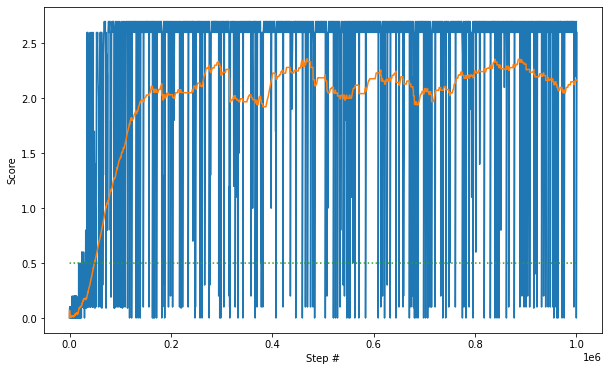

In [19]:
def plot_scores():
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    
    plt.plot(*zip(*scores))

    score_window = collections.deque(maxlen=100)
    windowed_average_scores = []
    for step, score in scores:
        score_window.append(score)
        windowed_average_scores.append((step, numpy.mean(score_window)))

    plt.plot(*zip(*windowed_average_scores))
    
    plt.plot(
        list(map(lambda pair: pair[0], scores)),
        [0.5] * len(scores),
        ":"
    )

    plt.ylabel('Score')
    plt.xlabel('Step #')
    plt.show()


plot_scores()

Finally, we can see how the agent performs:

In [21]:
agent.run_episode()

1.895000028423965

We can also load the "best" agent found during the training process:

In [22]:
agent.load()
agent.run_episode()

2.600000038743019

## Next steps

This environment stabalizes easily no only because the two agents are cooperating rather than competing with each other, but their local observations are also arguably sufficient for them to make decisions without caring much about what the other agent is doing. It would be interesting to try on the original Unity Tennis environment where the two agents are adversaries.

A major challenge of this environment is the sparsity of the rewards, which can easily cause training progress to stagnate, especially in the early training phase. It would be interesting to experiment with reward shaping techniques to alleviate this issue.

## References

- Lowe, R., Wu, Y., Tamar, A., Harb, J., Abbeel, P., & Mordatch, I. (2017). Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments. https://arxiv.org/abs/1706.02275
- Lillicrap, T. P. et al. (2015) ‘Continuous control with deep reinforcement learning’. Available at: http://arxiv.org/abs/1509.02971
- Fujimoto, S., van Hoof, H. and Meger, D. (2018) ‘Addressing Function Approximation Error in Actor-Critic Methods’. Available at: https://arxiv.org/abs/1802.09477
- Ackermann, J., Gabler, V., Osa, T., & Sugiyama, M. (2019). Reducing Overestimation Bias in Multi-Agent Domains Using Double Centralized Critics. https://arxiv.org/abs/1910.01465
- Schaul, T. et al. (2015) ‘Prioritized Experience Replay’. Available at: http://arxiv.org/abs/1511.05952
- Andrychowicz, M., Raichuk, A., Stańczyk, P., Orsini, M., Girgin, S., Marinier, R., Hussenot, L., Geist, M., Pietquin, O., Michalski, M., Gelly, S., & Bachem, O. (2020). What Matters In On-Policy Reinforcement Learning? A Large-Scale Empirical Study. https://arxiv.org/abs/2006.05990